### MFIN7034 Problem Set 2 – Factor and Portfolio Analysis

In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm

In [22]:
port_ret_df = pd.read_csv('data\portfolio_return_series.csv');
port_ret_df['YearMonth'] = pd.to_datetime(port_ret_df['YearMonth'])
port_ret_df.set_index('YearMonth', inplace=True)
port_ret_df = port_ret_df.apply(lambda x: x / 100)
port_ret_df.columns = port_ret_df.columns.str.strip()

In [50]:
port_ret_df.head()

,Small-cap growth,Small-cap value,Large-cap growth,Large-cap value,MKT
YearMonth,,,,,
1982-01-01,-0.0487,-0.0084,-0.0189,0.0043,-0.0004
1982-02-01,-0.0747,-0.0074,-0.0741,-0.0195,0.0018
1982-03-01,-0.0219,0.0149,-0.0196,0.0193,0.0247
1982-04-01,0.0653,0.0413,0.0573,0.0258,0.0526
1982-05-01,-0.0357,-0.0096,-0.0347,-0.0245,0.0010


#### 1.1 Certainty Equivalent Rate of Return

The value of ( A ) can be calculated using the formula:

$$
A = \frac{E(R_m) - R_f}{w \cdot \text{Var}(R_m)} 
$$

where:
- $E(R_m)$ is the expected return of the market.
- $R_f$ is the risk-free rate.
- $w$  is the weight in the market index.
- $\text{Var}(R_m)$ is the variance of the market return.

Calculated A: 5.81


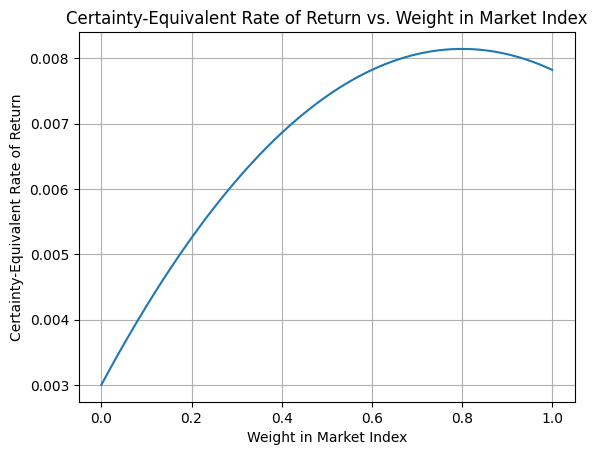

In [24]:
market_returns = port_ret_df['MKT']

# expected return and variance
E_Rm = market_returns.mean()
Var_Rm = market_returns.var()

R_f = 0.003  # Risk-free rate per month in decimal
w_optimal = 0.8  # Current allocation in the market index

A = (E_Rm - R_f) / (w_optimal * Var_Rm)
print(f"Calculated A: {A:.2f}")

# Plotting the certainty-equivalent rate of return
weights = np.linspace(0, 1, 100)
U_values = weights * E_Rm + (1 - weights) * R_f - 0.5 * A * (weights**2) * Var_Rm

plt.plot(weights, U_values)
plt.xlabel('Weight in Market Index')
plt.ylabel('Certainty-Equivalent Rate of Return')
plt.title('Certainty-Equivalent Rate of Return vs. Weight in Market Index')
plt.grid(True)
plt.show()

#### 1.2 Efficient Frontier and Tangent Portfolio

In [48]:
# Function to simulate portfolios
def simulate_portfolios(returns, R_f=0.003, num_portfolios=10000, constraints=None):
    num_assets = returns.shape[1]
    results = np.zeros((3, num_portfolios))
    weights_record = []

    for i in range(num_portfolios):
        if constraints == 'long_only':
            weights = np.random.random(num_assets)
            weights /= np.sum(weights)
        elif constraints == 'bounded':
            """
            # Weight Normalization (AI agent report point): 
            # Original code normalized bounded 
            # weights without ensuring the sum is non-zero, 
            # potentially creating NaN values
            weights = np.random.uniform(-0.5, 1.5, num_assets)
            weights /= np.sum(weights)
            """
            # Generate weights using Dirichlet distribution scaled to [-0.5, 1.5]
            alpha = np.ones(num_assets)
            weights = np.random.dirichlet(alpha)
            weights = (weights * 2) - 0.5  # Scale to [-0.5, 1.5] range

        weights_record.append(weights)
        portfolio_return = np.sum(weights * returns.mean()) * 12
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 12, weights)))
        results[0,i] = portfolio_return
        results[1,i] = portfolio_std_dev
        results[2,i] = (portfolio_return - R_f * 12) / portfolio_std_dev

    return results, weights_record

# Function to plot the efficient frontier
def plot_efficient_frontier(results, weights_record, returns, R_f=0.003):
    max_sharpe_idx = np.argmax(results[2])
    max_sharpe_return = results[0, max_sharpe_idx]
    max_sharpe_std_dev = results[1, max_sharpe_idx]
    max_sharpe_weights = weights_record[max_sharpe_idx]

    # Calculate tangent line parameters
    R_f_annual = R_f * 12
    slope = (max_sharpe_return - R_f_annual) / max_sharpe_std_dev
    x_tangent = np.linspace(0, max_sharpe_std_dev * 1.5, 100)
    y_tangent = R_f_annual + slope * x_tangent

    plt.figure(figsize=(10, 7))
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o', s=10, alpha=0.3)
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(max_sharpe_std_dev, max_sharpe_return, c='red', marker='*', s=500, label='Tangent Portfolio')
    plt.plot(x_tangent, y_tangent, '--', c='orange', label='Capital Market Line')
    # Set dynamic axis limits with 5% padding
    x_padding = 0.1 * np.max(results[1,:])
    y_padding = 0.1 * np.max(results[0,:])
    plt.xlim(max(0, np.min(results[1,:]) - x_padding), 
             np.max(results[1,:]) + x_padding)
    plt.ylim(np.min(results[0,:]) - y_padding, 
             np.max(results[0,:]) + y_padding)
    plt.title(f'Efficient Frontier for Scenario')
    plt.xlabel('Volatility (Std. Deviation)')
    plt.ylabel('Expected Return')
    plt.legend(labelspacing=0.8)
    plt.show()

    print(f'Tangent Portfolio Weights:')
    for i, col in enumerate(returns.columns):
        print(f"{col}: {max_sharpe_weights[i]:.2f}")

    print(f'Sharpe Ratio: {slope:.2f}')
    certainty_equivalent_return = max_sharpe_return - 0.5 * A * (max_sharpe_std_dev ** 2)
    print(f'Certainty Equivalent Rate of Return: {certainty_equivalent_return:.4f}')

========== Scenarios 1 ==========


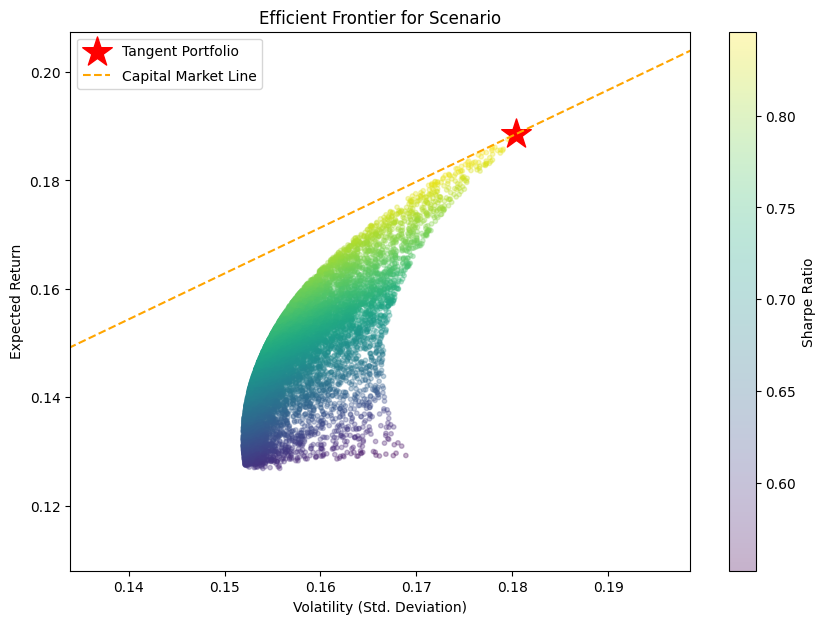

Tangent Portfolio Weights:
MKT: 0.97
Large-cap growth: 0.02
Large-cap value: 0.00
Sharpe Ratio: 0.85
Certainty Equivalent Rate of Return: 0.0940


========== Scenarios 2 ==========


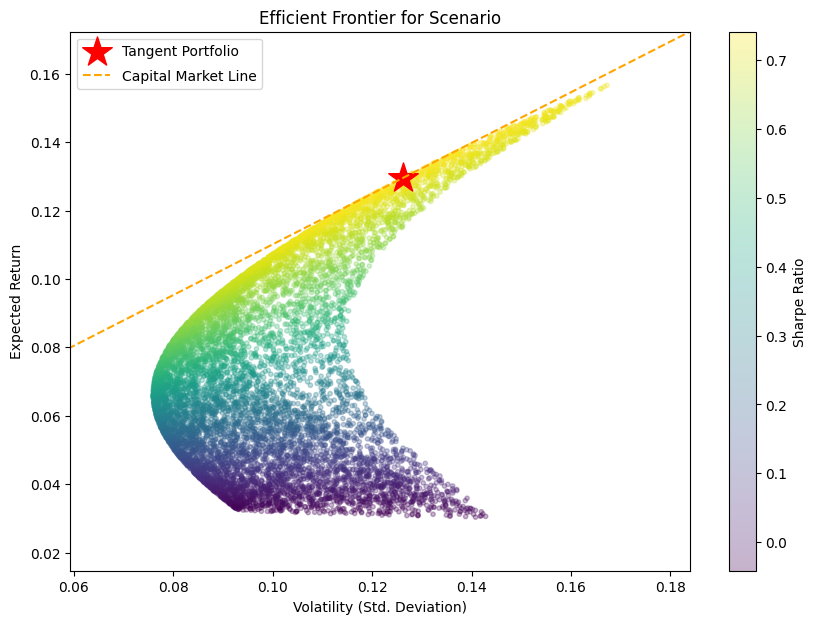

Tangent Portfolio Weights:
MKT: 1.06
Large-cap growth: -0.06
Large-cap value: -0.50
Sharpe Ratio: 0.74
Certainty Equivalent Rate of Return: 0.0832


========== Scenarios 3 ==========


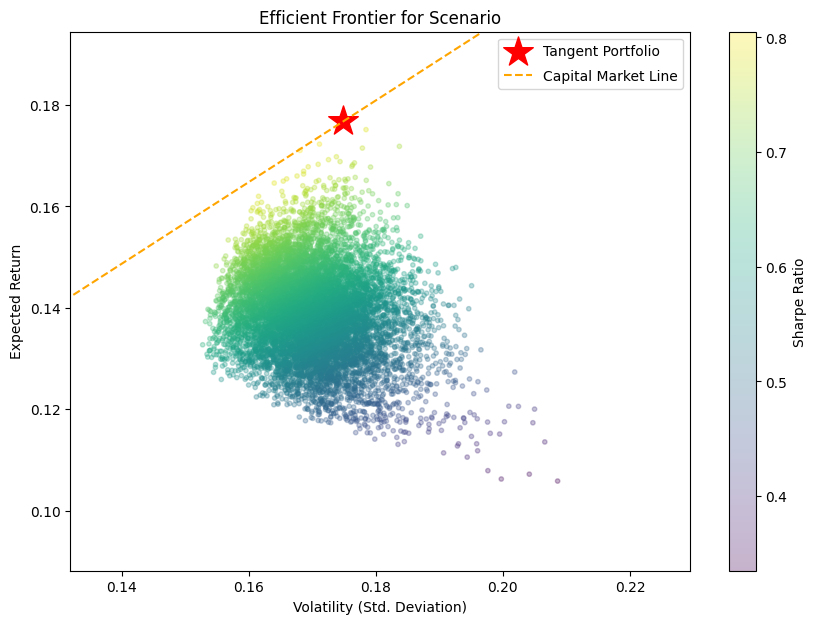

Tangent Portfolio Weights:
MKT: 0.74
Large-cap growth: 0.08
Large-cap value: 0.06
Small-cap growth: 0.01
Small-cap value: 0.12
Sharpe Ratio: 0.81
Certainty Equivalent Rate of Return: 0.0879


========== Scenarios 4 ==========


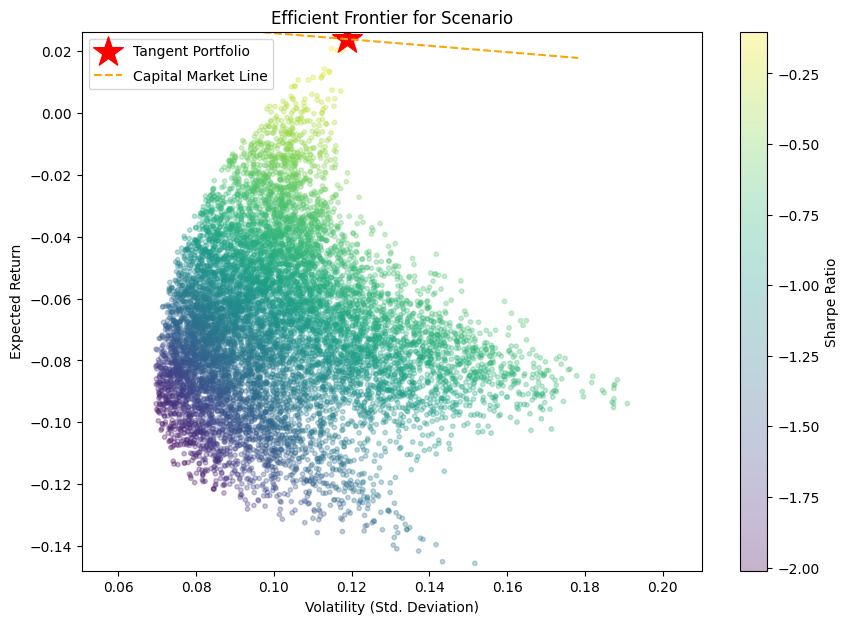

Tangent Portfolio Weights:
MKT: 1.32
Large-cap growth: -0.46
Large-cap value: -0.47
Small-cap growth: -0.49
Small-cap value: -0.40
Sharpe Ratio: -0.10
Certainty Equivalent Rate of Return: -0.0172




In [49]:
scenarios = [
    ('long_only', ['MKT', 'Large-cap growth', 'Large-cap value']),
    ('bounded', ['MKT', 'Large-cap growth', 'Large-cap value']),
    ('long_only', ['MKT', 'Large-cap growth', 'Large-cap value', 'Small-cap growth', 'Small-cap value']),
    ('bounded', ['MKT', 'Large-cap growth', 'Large-cap value', 'Small-cap growth', 'Small-cap value'])
]

for i, (constraint, assets) in enumerate(scenarios, 1):
    selected_returns = port_ret_df[assets]
    results, weights_record = simulate_portfolios(selected_returns, num_portfolios=10000, constraints=constraint)
    print(f'========== Scenarios {i} ==========')
    plot_efficient_frontier(results, weights_record, selected_returns)
    print('\n')

#### 2.1 Factor Zoo Deeper Explorations - Trials

In [136]:
fund_factors_df = pd.read_csv('data/fundamental_factors.csv')
fund_factors_df = fund_factors_df[['LPERMNO', 
                                   'datadate', 
                                   'chq', 
                                   'dd1q', 
                                   'dlttq', 
                                   'drcq', 
                                   'dvintfq', 
                                   'epsfi12', 
                                   'esubq', 
                                   'lctq', 
                                   'lltq', 
                                   'oiadpq', 
                                   'capxy']]
fund_factors_df['datadate'] = pd.to_datetime(fund_factors_df['datadate'])
fund_factors_df.head()

,LPERMNO,datadate,chq,dd1q,dlttq,drcq,dvintfq,epsfi12,esubq,lctq,lltq,oiadpq,capxy
0,46850,1982-03-31,NaN,NaN,258.599,NaN,NaN,NaN,NaN,NaN,NaN,67.200,NaN
1,46850,1982-06-30,NaN,NaN,408.500,NaN,NaN,NaN,NaN,NaN,NaN,113.700,NaN
2,46850,1982-09-30,NaN,NaN,408.099,NaN,NaN,NaN,NaN,NaN,NaN,133.699,NaN
3,46850,1982-12-31,NaN,NaN,413.599,NaN,NaN,NaN,NaN,NaN,NaN,108.799,NaN
4,46850,1983-03-31,NaN,NaN,425.200,NaN,NaN,NaN,NaN,NaN,NaN,159.800,NaN


In [137]:
stock_ret_df = pd.read_csv('data/monthly_stock_returns.csv')
stock_ret_df['Month'] = pd.to_datetime(stock_ret_df['YYYYMM'], format='%Y%m')
stock_ret_df.drop(columns=['YYYYMM'], inplace=True)
stock_ret_df.apply(pd.to_numeric, errors='coerce').astype(float)
stock_ret_df.head()
stock_ret_df['Month'].unique()

<DatetimeArray>
['2000-01-01 00:00:00', '2000-02-01 00:00:00', '2000-03-01 00:00:00',
 '2000-04-01 00:00:00', '2000-05-01 00:00:00', '2000-06-01 00:00:00',
 '2000-07-01 00:00:00', '2000-08-01 00:00:00', '2000-09-01 00:00:00',
 '2000-10-01 00:00:00',
 ...
 '2022-03-01 00:00:00', '2022-04-01 00:00:00', '2022-05-01 00:00:00',
 '2022-06-01 00:00:00', '2022-07-01 00:00:00', '2022-08-01 00:00:00',
 '2022-09-01 00:00:00', '2022-10-01 00:00:00', '2022-11-01 00:00:00',
 '2022-12-01 00:00:00']
Length: 276, dtype: datetime64[ns]

In [139]:
# Extract year and month from 'Month' and 'datadate' columns
stock_ret_df['YearMonth'] = stock_ret_df['Month'].dt.to_period('M')

# need to shift 1 month down, because 1982-03-31 should be resampled to 1982-04 not 03
fund_factors_df['YearMonth'] = (fund_factors_df['datadate'] + pd.DateOffset(months=1)).dt.to_period('M')

merged_df = pd.merge(stock_ret_df, fund_factors_df, left_on=['PERMNO', 'YearMonth'], right_on=['LPERMNO', 'YearMonth'], how='inner')

In [141]:
merged_df.head() # TODO: should fill each month with the same fundamental factor (quaterly)

,PERMNO,MthPrc,MthRet,Month,YearMonth,LPERMNO,datadate,chq,dd1q,dlttq,drcq,dvintfq,epsfi12,esubq,lctq,lltq,oiadpq,capxy
0,10324,52.0000,0.155556,2000-01-01,2000-01,10324,1999-12-31,NaN,NaN,272.622,NaN,NaN,1.71,NaN,117.244,274.725,65.436,52.910
1,10324,48.8125,-0.026185,2000-04-01,2000-04,10324,2000-03-31,NaN,NaN,272.988,NaN,NaN,1.91,NaN,122.537,275.098,66.145,14.548
2,10324,69.4375,0.168244,2000-07-01,2000-07,10324,2000-06-30,NaN,NaN,273.223,NaN,NaN,2.41,NaN,121.163,275.960,70.075,34.187
3,10324,71.0000,0.041247,2000-10-01,2000-10,10324,2000-09-30,NaN,NaN,273.477,NaN,NaN,2.61,NaN,154.259,285.063,68.480,49.973
4,10324,86.5625,-0.037526,2001-01-01,2001-01,10324,2000-12-31,NaN,NaN,454.236,NaN,NaN,1.35,NaN,166.583,582.190,46.578,72.591


In [150]:
def calculate_factor_returns(data, factor):
    factor_returns = []

    # Group by month
    for month, group in data.groupby('YearMonth'):
        # Sort by the selected factor
        sorted_group = group.sort_values(by=factor, ascending=False)
        
        # Calculate top 20% and bottom 20%
        top_20 = sorted_group.head(int(len(sorted_group) * 0.2))
        bottom_20 = sorted_group.tail(int(len(sorted_group) * 0.2))
        
        # Calculate average returns
        top_20_return = top_20['MthRet'].mean()
        bottom_20_return = bottom_20['MthRet'].mean()
        
        # Calculate factor return
        factor_return = top_20_return - bottom_20_return
        factor_returns.append((month, factor_return))
    
    result_df = pd.DataFrame(factor_returns, columns=['Date', f'{factor}_Return'])
    result_df['Date'] = result_df['Date'].dt.to_timestamp()
    return result_df

In [151]:
factor_return_test_df = calculate_factor_returns(merged_df, 'dlttq')
factor_return_test_df.head()

,Date,dlttq_Return
0,2000-01-01,0.021472
1,2000-02-01,-0.253838
2,2000-03-01,0.439591
3,2000-04-01,0.039496
4,2000-05-01,0.070229


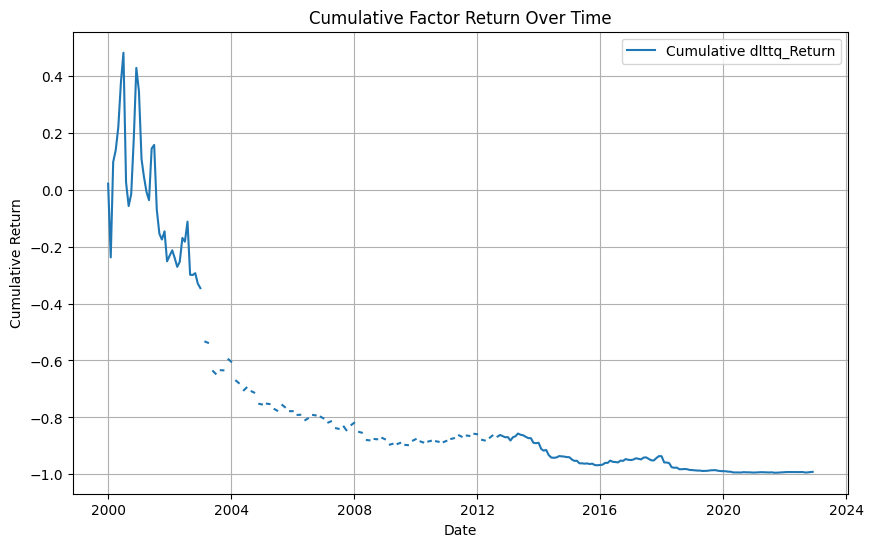

In [152]:
import matplotlib.pyplot as plt

# Calculate cumulative return
factor_return_test_df['Cumulative_Return'] = (1 + factor_return_test_df['dlttq_Return']).cumprod() - 1

plt.figure(figsize=(10, 6))
plt.plot(factor_return_test_df['Date'], factor_return_test_df['Cumulative_Return'], label='Cumulative dlttq_Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Factor Return Over Time')
plt.legend()
plt.grid(True)
plt.show()